In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
import time

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
tf.gfile = tf.io.gfile

from tensorflow.keras.models import model_from_json

%run ../utils/object_detection_utils.ipynb
%run ../utils/image_utils.ipynb
%run ../utils/data_utils.ipynb

ROOT = "/mnt/nvme-storage/pfauregi"

# Loading sample image

In [2]:
sample = load_image(os.path.join(ROOT,"datasets/micro_samples/sample_04.tiff"))

# Detection

In [3]:
detection_model_path = os.path.join(ROOT,"training/obj_detection/ws_bd/models/model/export/saved_model/")
labels_path = os.path.join(ROOT,"artificial_datasets/dataset01_tfr/binary_label_map.pbtxt")

In [4]:
def run_detection(model_path, sample):
    start = time.time()
    model = tf.saved_model.load(model_path)
    model = model.signatures['serving_default']
    detection_results = run_inference_for_single_image(model, sample)
    print("Detection processed in", time.time()-start, "s!")
    return detection_results

def get_thumbails_batch(sample, detection, score_thresold=0.5, verbose=False):
    thumbails = {}
    thumbails["batch"] = []
    thumbails["bounding_box"] = []
    thumbails["score"] = []
    image_detections = sample.copy()
    height, width, channels = image_detections.shape
    for box, score in zip(detection['detection_boxes'], detection['detection_scores']):
        if score>score_thresold:
            ymin, xmin, ymax, xmax = int(box[0]*width), int(box[1]*height), int(box[2]*width), int(box[3]*height)
            if verbose: image_detections = cv2.rectangle(image_detections, (xmin, ymin), (xmax, ymax), (255, 0, 0), 4)
            thumbail = sample[ymin:ymax, xmin:xmax, :]
            thumbail = convert_to_square(thumbail, new_size=256)
            thumbails["batch"].append(thumbail)
            thumbails["bounding_box"].append([ymin, xmin, ymax, xmax])
            thumbails["score"].append(score)
    thumbails["batch"] = np.array(thumbails["batch"])
    if verbose: 
        display(Image.fromarray(image_detections).resize((int(0.2*width), int(0.2*height))))
        display(Image.fromarray(thumbails["batch"][1]))
        thumbails["batch"][1].shape[0]
    return thumbails

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Detection processed in 10.003829002380371 s!


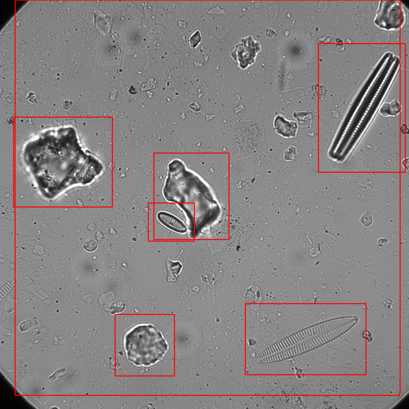

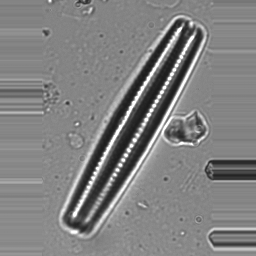

In [5]:
detection_results = run_detection(detection_model_path, sample)
thumbails = get_thumbails_batch(sample, detection_results, score_thresold=0.99, verbose=True)

# Classification

In [6]:
class_root = "/home/pfauregi/Super-Diatomee-Classifier/diatom_classification/thumbnail_classification/saved_models/"
class_model_path = os.path.join(class_root, "model.json")
class_model_weights = os.path.join(class_root, "model.h5")

inv_id_map = {v: k for k, v in get_selected_taxons('../selected_taxons.txt').items()} 

In [7]:
def run_classification(class_model_path, class_model_weights, thumbails_batch):
    json_file = open(class_model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(class_model_weights)
    loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    out = loaded_model.predict(thumbails_batch, batch_size=thumbails_batch.shape[0], use_multiprocessing=True)
    return out

In [9]:
out = run_classification(class_model_path, class_model_weights, thumbails["batch"])
thumbails["labels"] = [inv_id_map[np.argmax(pred)] for pred in out]

In [21]:
scale_factor = 0.4

image_detections = sample.copy()
for bb, label in zip(thumbails["bounding_box"], thumbails["labels"]):
    color = (255, 0, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    ymin, xmin, ymax, xmax = bb
    image_detections = cv2.rectangle(image_detections, (xmin, ymin), (xmax, ymax), color, 4)
    img_bb = cv2.putText(image_detections,  label, (xmin, ymin+80), font, 3, color, 6, cv2.LINE_AA) 
height, width, channels = image_detections.shape
display(Image.fromarray(image_detections).resize((int(scale_factor*width), int(scale_factor*height))))

SyntaxError: invalid syntax (<ipython-input-21-03ff1dce87c3>, line 9)